<div class="jumbotron text-left"><b>
This tutorial describes how to use the SMT toolbox with multifidelity data, using a co-kriging approach.</b></div>

Mauricio Castano Aguirre, July 2024.

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow the link : 
</p>

https://github.com/SMTorg/SMT/blob/master/README.md


<p class="alert alert-success" style="padding:1em">
The doc is available here: 
</p>

https://smt.readthedocs.io/en/latest/


For the multifidelity extension, a description of the algorithm is available here (Pending of add a link)

# When the pull request is done

In [1]:
!pip install smt

You should consider upgrading via the 'D:\mcastano\.pyenv\pyenv-win\versions\3.11.0b3\python.exe -m pip install --upgrade pip' command.


# Multi-Fidelity co-Kriging 

We are interested in learning a high-fidelity function while using low-fidelity information sources to enhance the model, for that we use the auto-regressive formulation of Kennedy O'Hagan/Le Gratiet.

<p class="alert alert-warning" style="padding:1em">
For this formulation, a nested DoE is not necessary. The following formulation is not required, but it could be used.
 </p>
    
$$X_{HF} \subset X_{LF}$$

### Kennedy O'Hagan/Le Gratiet auto-regressive formulation:
To perform the co-kriging, we first need to introduce the auto-regressive formulation, we learn the relationship between every two consecutive fidelity levels (scaling factor $\rho_{k-1}$ and discrepancy function $\gamma_k(\cdot)$ are used for that).

$$
    Y_{k} = \rho_{k-1}\;Y_{k-1} + \gamma_k\\ k>0
$$

In this case we have the lowest fidelity $Y_{0}\sim\mathcal{GP}(0,K(\cdot,\cdot))$, $\rho_{k}$ being a scale factor and $\gamma_k\sim\mathcal{GP}({0,K(\cdot,\cdot)})$ to measure the discrepancies between $Y_{k}$ and $Y_{k-1}$. After, we model the higher fidelity levels using the auto-regressive formulation.

We define $K(\cdot,\cdot)$ as some kernel function for covariance calculation

This generally results in a better surrogate model compared to training the high-fidelity alone.

### SMT 
SMT is a joint library between NASA, UoM, ONERA and ISAE-SUPAERO. It offers many surrogate modeling tools with a focus on derivatives. Le Gratiet's formulation was implemented as part of SMT.

After dowmloading and installing SMT library from: https://github.com/SMTorg/smt

We import the needed packages

In [2]:
## Locally for the moment
import os
import sys 
sys.path.append(os.path.abspath("D:/mcastano/Documents/Repositories/smt/smt/applications"))

In [3]:
from mfck import MFCK
## When the pull request is done just
#from smt.applications import MFCK

In [4]:
from smt.applications.mfk import MFK, NestedLHS
from smt.sampling_methods import LHS
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## 1- Build the multi-fidelity setup

In [5]:
def Forrester_HF(x):
    return ((6*x-2)**2)*np.sin(12*x-4)

def Forrester_LF(x):
    return 0.5*((6*x-2)**2)*np.sin(12*x-4) + 10*(x-0.5) - 5

def Forrester_MF(x):
    return Forrester_LF + 3

In [6]:

N = 100  #Number of samples for validation

xlimits = np.array([[0.0, 1.0]])   #limits of x for the test vector, and limits for the plots
ylimits = np.array([[-25.0, 25.0]]) #used for  y limits of plots

ndoe = 4  # Design Of Experiments, N observations of high fidelity and 2*N in low fidelity 

n_start=100

opti='Cobyla'


x = np.linspace(xlimits[0][0], xlimits[0][1], N, endpoint=True).reshape(-1, 1)

LF=Forrester_LF(x)
HF=Forrester_HF(x)

Text(0, 0.5, '$y$')

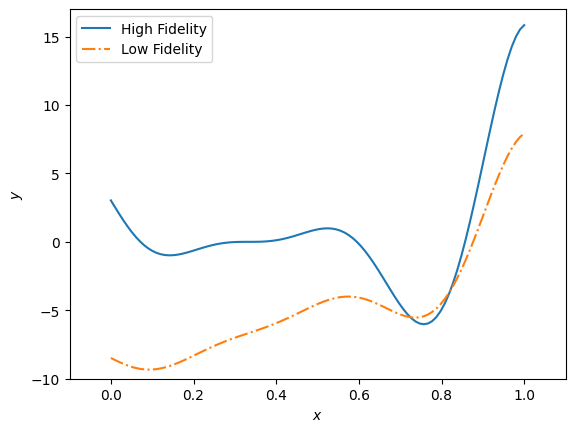

In [7]:
# Ploting High and low fidelity functions

plt.figure()
plt.plot(x, HF, label ='High Fidelity')
plt.plot(x, LF, linestyle = '-.' , label ='Low Fidelity')

plt.legend(loc=0)
plt.ylim(-10,17)
plt.xlim(-0.1,1.1)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

#### Sampling
The idea here is the same as the MFK example, we want to cover as much space as possible with low-fidelity data and use enough high fidelity samples to learn the relationship between fidelity-levels.

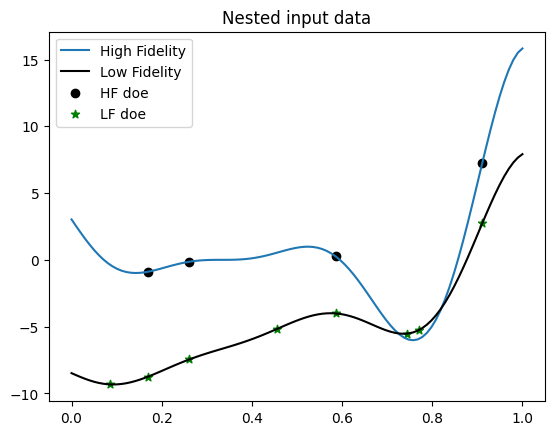

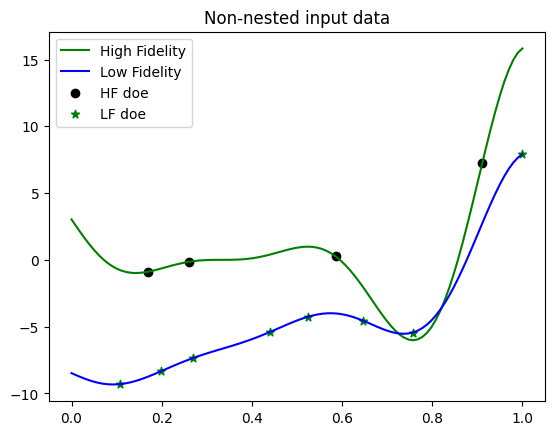

In [8]:
# LHS sampling with 2 levels of fidelity
ndim = 1 #1 dimension example
nlvl = 2 # 2 levels
ndoe_HF = 4 #4 high fidelity points

#Nested DOE
xlimits = np.array([[0.0, 1.0]])
xdoes = NestedLHS(nlevel=nlvl, xlimits=xlimits, random_state=51)

# seeds 2, 9, 12, 51


xt_c, xt_e = xdoes(ndoe_HF)
ndoe_LF = np.shape(xt_c)[0]
yt_e = Forrester_HF(xt_e)
yt_c = Forrester_LF(xt_c)


#Creation of non-nested input data, displacing the LF points randomly using a delta

#xlimits = np.array([[0.0, 4.0], [0.0, 3.0]])
sampling = LHS(xlimits=xlimits,criterion='ese')

x0_LF = sampling(ndoe_LF)

x0_HF = xt_e

y0_LF = Forrester_LF(x0_LF)
y0_HF = Forrester_HF(x0_HF)


plt.figure()
plt.title("Nested input data")
plt.plot(x, HF, label ='High Fidelity')
plt.plot(x, LF , c ='k', label ='Low Fidelity')
plt.scatter(xt_e, yt_e, marker = 'o' , color ='k', label ='HF doe')
plt.scatter(xt_c, yt_c, marker = '*' , color ='g', label ='LF doe')
plt.legend()


plt.figure()
plt.title("Non-nested input data")
plt.plot(x, HF,c='g', label ='High Fidelity')
plt.plot(x, LF , c ='b', label ='Low Fidelity')
plt.scatter(x0_HF, y0_HF, marker = 'o' , color ='k', label ='HF doe')
plt.scatter(x0_LF, y0_LF, marker = '*' , color ='g', label ='LF doe')
plt.legend()

# 2. Training the model

## 2.1-Training for the nested input data

In [9]:
#Initial parameters for MFCK
theta0 = np.array([[7.]])
theta_bounds = [1e-2, 50]

# Data structure for MFCK (Temporal)
doe = np.vstack([np.hstack([xt_c, np.zeros((xt_c.shape[0],1))]), np.hstack([xt_e, np.ones((xt_e.shape[0],1))])])
doe_response = np.vstack([yt_c,yt_e])

mfck = MFCK(theta0 = theta0, theta_bounds = theta_bounds, hyper_opt = 'Cobyla', n_start = n_start) #Inizialitation for any level sigma,lengthscale and rho
mfck.set_training_values(doe, doe_response)
mfck.train()

medianmf0,varmf0,medianmf1,varmf1 = mfck.predict(x)
varmf0=np.diag(varmf0).reshape(-1,1)
varmf1=np.diag(varmf1).reshape(-1,1)


#Initial parameters for MFK
theta0 = np.array([[7.],[1.08]])
theta_bounds = [1e-2, 50]

sm = MFK(hyper_opt=opti,theta0= theta0, theta_bounds = theta_bounds,propagate_uncertainty=True, n_start=n_start)#,hyper_opt='cobyla')
sm.set_training_values(xt_c, yt_c, name=0)
sm.set_training_values(xt_e, yt_e)
sm.train()

#HF
mean_nmf_hfn = sm.predict_values(x)
va_nmf_hfn = sm.predict_variances(x)
# LF
mean_nmf_lfn = sm._predict_intermediate_values(x, 1)
va_nmf_lfn, _ =  sm.predict_variances_all_levels(x)
va_nmf_lfn = va_nmf_lfn[:,0].reshape(-1,1)



 MFCK 




__________Experiment with 2 lvl and 1 Dim________



Training...
Predicting...
___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...


D:\mcastano\Documents\Repositories\smt\smt\surrogate_models\krg_based.py:968: UserWarning: R is too ill conditioned. Poor combination of regression model and observations.
  warnings.warn(


   Training - done. Time (sec):  0.6433184
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   


In [10]:
print(sm.optimal_theta)

[array([1.0895644]), array([0.01])]


In [11]:
mfck.theta

array([37.9790314 , 12.76566934, 32.71219556,  1.1881773 ,  1.42823838])

## 2.2-Training for non-nested input data

In [12]:
#Using MFK
sm1 =  MFK(theta0= theta0, theta_bounds = theta_bounds, propagate_uncertainty=False, n_start=n_start)#,hyper_opt=opti)
sm1.set_training_values(x0_LF, y0_LF, name=0)
sm1.set_training_values(x0_HF, y0_HF)
sm1.train()

mean_nmf_hf = sm1.predict_values(x)
va_nmf_hf = sm1.predict_variances(x)

mean_nmf_lf = sm1._predict_intermediate_values(x, 1)
var0, _ =  sm1.predict_variances_all_levels(x)
var0 = var0[:,0].reshape(-1,1)



#Initial parameters for MFCK
theta0 = np.array([[7.]])
theta_bounds = [1e-2, 50]

# Data structure for MFCK (Temporal)
doe = np.vstack([np.hstack([x0_LF, np.zeros((x0_LF.shape[0],1))]), np.hstack([x0_HF, np.ones((x0_HF.shape[0],1))])])
doe_response = np.vstack([y0_LF,y0_HF])

#Using MFCK
mfck1 = MFCK(hyper_opt=opti,n_start=n_start)
mfck1.set_training_values(doe,doe_response)
mfck1.train()
a,m,a1,m1 = mfck.predict(x)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...


D:\mcastano\Documents\Repositories\smt\smt\surrogate_models\krg_based.py:968: UserWarning: R is too ill conditioned. Poor combination of regression model and observations.
  warnings.warn(


   Training - done. Time (sec):  1.5381608
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   

 MFCK 




__________Experiment with 2 lvl and 1 Dim________



Training...
Predicting...


# 3-Plotting results

Text(0.5, 1.0, 'MFCK, non-nested input data')

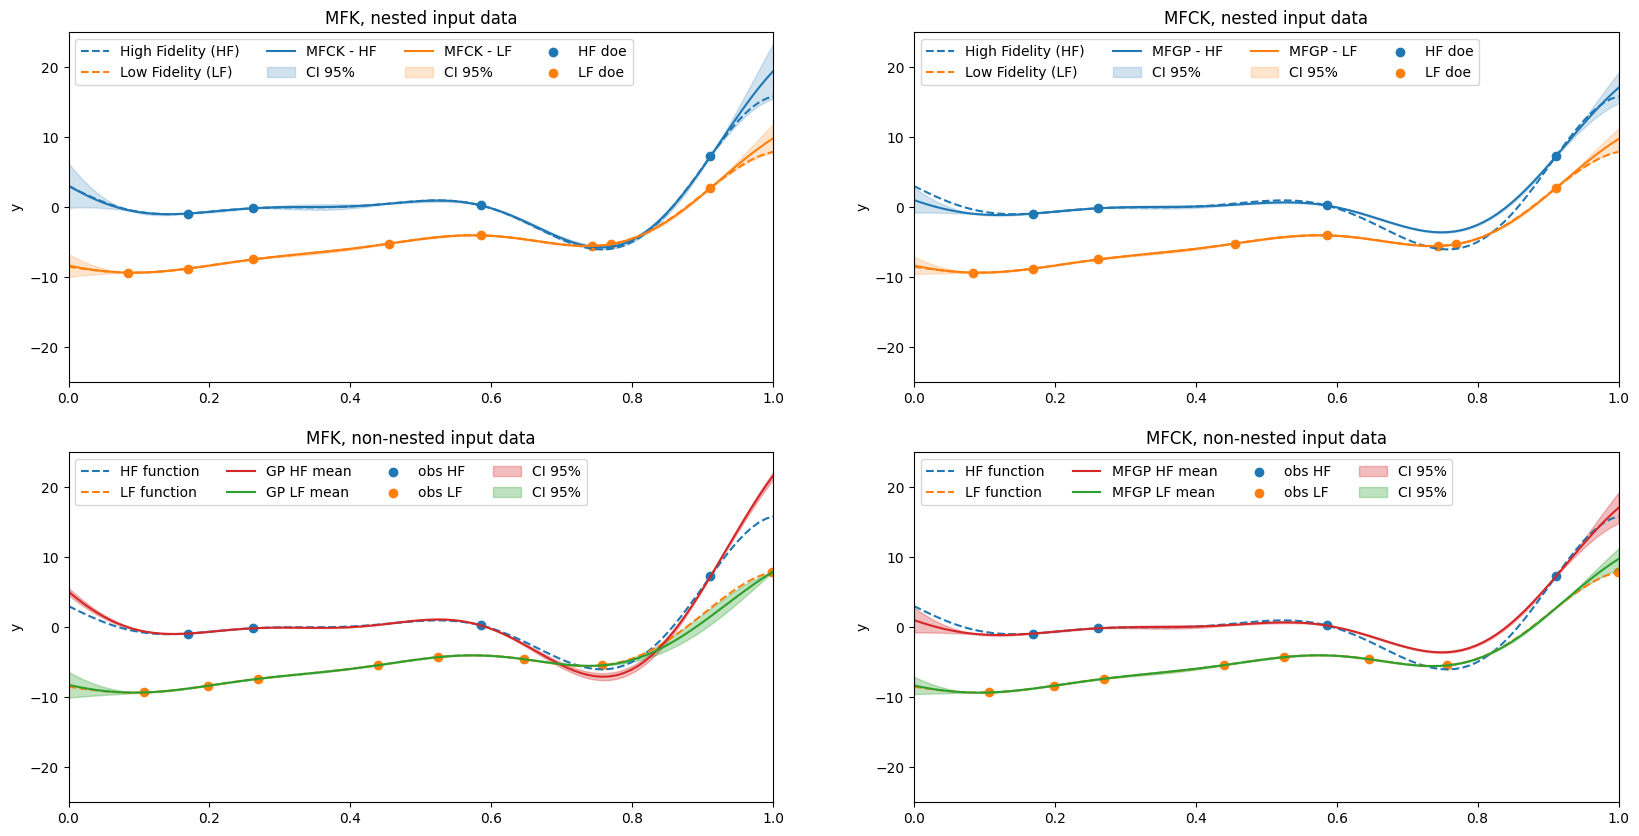

In [13]:
plt.figure(figsize = (20, 10))
    
plt.subplot(2,2,1)
plt.plot(x, HF, '--C0', label='High Fidelity (HF)')
plt.plot(x, LF, '--C1', label='Low Fidelity (LF)')
plt.plot(x, mean_nmf_hfn, 'C0', label='MFCK - HF')
plt.fill_between(np.ravel(x), np.ravel(mean_nmf_hfn-1.96*np.sqrt(va_nmf_hfn)),
                    np.ravel(mean_nmf_hfn+1.96*np.sqrt(va_nmf_hfn)),
                    color='C0',alpha=0.2, label ='CI 95%')
plt.plot(x, mean_nmf_lfn, 'C1', label='MFCK - LF')
plt.fill_between(np.ravel(x), np.ravel(mean_nmf_lfn-1.96*np.sqrt(va_nmf_lfn)),
                    np.ravel(mean_nmf_lfn+1.96*np.sqrt(va_nmf_lfn)),
                    color='C1',alpha=0.2, label ='CI 95%')


plt.scatter(xt_e, yt_e, color='C0', label='HF doe')
plt.scatter(xt_c, yt_c, color='C1', label='LF doe')

plt.ylim(ylimits[0][0],ylimits[0][1]); plt.xlim(xlimits[0][0],xlimits[0][1])
plt.xlabel(''); plt.ylabel('y')
plt.legend(loc=2, ncol=4)
plt.title('MFK, nested input data')





plt.subplot(2,2,2)
plt.plot(x, HF, '--C0', label='High Fidelity (HF)')
plt.plot(x, LF, '--C1', label='Low Fidelity (LF)')
plt.plot(x, medianmf0, 'C0', label='MFGP - HF')

plt.fill_between(np.ravel(x), np.ravel(medianmf0-1.96*np.sqrt(varmf0)),
                    np.ravel(medianmf0+1.96*np.sqrt(varmf0)),
                    color='C0',alpha=0.2, label ='CI 95%')
plt.plot(x, medianmf1, 'C1', label='MFGP - LF')
plt.fill_between(np.ravel(x), np.ravel(medianmf1-1.96*np.sqrt(varmf1)),
                    np.ravel(medianmf1+1.96*np.sqrt(varmf1)),
                    color='C1',alpha=0.2, label ='CI 95%')


plt.scatter(xt_e, yt_e, color='C0', label='HF doe')
plt.scatter(xt_c, yt_c, color='C1', label='LF doe')



plt.ylim(ylimits[0][0],ylimits[0][1]); plt.xlim(xlimits[0][0],xlimits[0][1])
plt.xlabel(''); plt.ylabel('y')
plt.legend(loc=2, ncol=4)
plt.title('MFCK, nested input data')


plt.subplot(2,2,3)
# plot LF and HF target functions
plt.plot(x, HF, "C0--",label="HF function")
plt.plot(x, LF, "C1--",label="LF function")

plt.plot(x, mean_nmf_hf, "C3",label="GP HF mean")
plt.plot(x, mean_nmf_lf, "C2",label="GP LF mean")

plt.scatter(x0_HF, y0_HF,  color = 'C0', label = "obs HF")
plt.scatter(x0_LF, y0_LF,  color = 'C1', label = "obs LF")

upperBound = mean_nmf_hf.flatten() + 1.96*np.sqrt(np.abs((va_nmf_hf.flatten())))
lowerBound = mean_nmf_hf.flatten() - 1.96*np.sqrt(np.abs((va_nmf_hf.flatten())))

upperBound1 = mean_nmf_lf.flatten() + 1.96*np.sqrt(np.abs((var0.flatten())))
lowerBound1 = mean_nmf_lf.flatten() - 1.96*np.sqrt(np.abs((var0.flatten())))

plt.fill_between(x.flatten(), lowerBound.flatten(), upperBound.flatten(),
    label="CI 95%",
    color="C3", alpha=0.3)

plt.fill_between(x.flatten(), lowerBound1.flatten(), upperBound1.flatten(),
    label="CI 95%",
    color="C2", alpha=0.3)

plt.ylim(ylimits[0][0],ylimits[0][1]); plt.xlim(xlimits[0][0],xlimits[0][1])
plt.xlabel(''); plt.ylabel('y')
plt.legend(loc=2, ncol=4)
plt.title('MFK, non-nested input data')


plt.subplot(2,2,4)

plt.plot(x, HF, "C0--",label="HF function")
plt.plot(x, LF, "C1--",label="LF function")

plt.plot(x, a, "C3",label="MFGP HF mean")

plt.plot(x, a1, "C2",label="MFGP LF mean")
plt.scatter(x0_HF, y0_HF, color = 'C0', label = "obs HF")
plt.scatter(x0_LF, y0_LF, color = 'C1', label = "obs LF")

upperBound2 = a.flatten() + 1.96*np.sqrt(np.diag(m))
lowerBound2 = a.flatten() - 1.96*np.sqrt(np.diag(m))

upperBound3 = a1.flatten() + 1.96*np.sqrt(np.diag(m1))
lowerBound3 = a1.flatten() - 1.96*np.sqrt(np.diag(m1))

plt.fill_between(x.flatten(), lowerBound2.flatten(), upperBound2.flatten(),
    label="CI 95%",
    color="C3", alpha=0.3)

plt.fill_between(x.flatten(), lowerBound3.flatten(), upperBound3.flatten(),
    label="CI 95%",
    color="C2", alpha=0.3)

plt.ylim(ylimits[0][0],ylimits[0][1]); plt.xlim(xlimits[0][0],xlimits[0][1])
plt.xlabel(''); plt.ylabel('y')
plt.legend(loc=2, ncol=4)
plt.title('MFCK, non-nested input data')

## 4-RMSE

In [14]:
# Add RMSE

#MFCK: RMSE HF non-nested
rmseHF = np.sqrt(np.mean((HF.flatten() - a.flatten())**2))
#RMSE Low Fidelity non-nested
rmseLF = np.sqrt(np.mean((LF.flatten() - a1.flatten())**2))

#MFK: RMSE HF non-nested
rmseHF1 = np.sqrt(np.mean((HF.flatten() - mean_nmf_hf.flatten())**2))
#RMSE LF non-nested
rmseLF1 = np.sqrt(np.mean((LF.flatten() - mean_nmf_lf.flatten())**2))


#MFCK: RMSE HF nested
rmseHF2 = np.sqrt(np.mean((HF.flatten() - medianmf0.flatten())**2))
#      RMSE LF nested
rmseLF2 = np.sqrt(np.mean((LF.flatten() - medianmf1.flatten())**2))

#MFK: RMSE LF nested
rmseHF3 = np.sqrt(np.mean((HF.flatten() - mean_nmf_hfn.flatten())**2))
#      RMSE LF nested
rmseLF3 = np.sqrt(np.mean((LF.flatten() - mean_nmf_lfn.flatten())**2))

print('RMSE for nested')
print('           HF                     LF')
print('MFK  :',rmseHF3,rmseLF3)
print('MFCK :',rmseHF2,rmseLF2)


print('\n')

print('RMSE for non-nested ')
print('           HF                     LF')
print('MFK  :',rmseHF1,rmseLF1)
print('MFCK :',rmseHF,rmseLF)


RMSE for nested
           HF                     LF
MFK  : 0.5512608876108457 0.2973843530934318
MFCK : 1.0551438469255847 0.281150404389617


RMSE for non-nested 
           HF                     LF
MFK  : 1.0955123807477642 0.39292876992319015
MFCK : 1.0551438469255847 0.281150404389617


## For 2D experimental data

In [15]:
from matplotlib import cm
def Rosen_HF(point):
    # Expensive Rosen function
    res = 100*(point[:,1] - point[:,0]**2)**2 + (1.0 - point[:,0])**2 
    return res

def Rosen_LF(point):
    # Expensive Rosen function
   
    #res = 5*((1.0 - point[:,0])**2 + 100*(point[:,1] - point[:,0]**2)**2) + 0.1*np.sin(10*point[:,0] + 5*point[:,1])
   
    res = 50*(point[:,1] - point[:,0]**2)**2 + (-2 - point[:,0])**2 - (0.5*point[:,0])
    
    return res

D:\mcastano\AppData\Local\Temp\ipykernel_9176\2579495183.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
D:\mcastano\AppData\Local\Temp\ipykernel_9176\2579495183.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


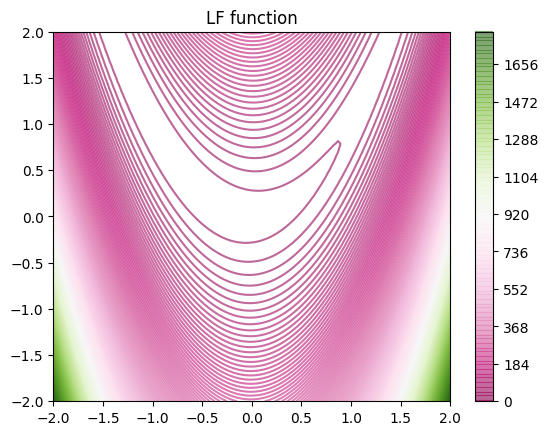

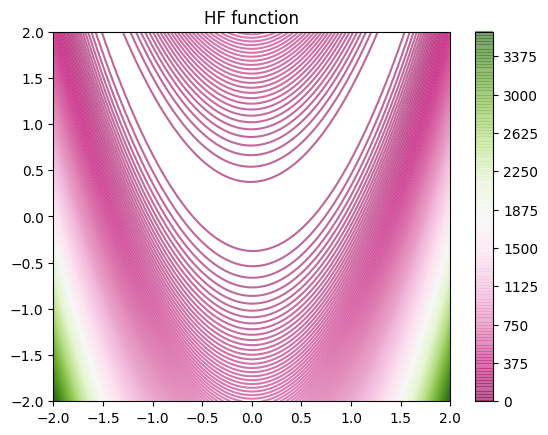

In [16]:
#HF observations
num = 5
x = np.linspace(-2., 2., num)
y = np.linspace(-2.,2., num)
xv, yv = np.meshgrid(x, y)

x_hf = np.array([np.ravel(xv), np.ravel(yv)]).T
z_HF = np.zeros([num*num, 1])
z_HF = Rosen_HF(x_hf)

# LF observations
num = 10
x = np.linspace(-2., 2., num)
y = np.linspace(-2.,2., num)
xv, yv = np.meshgrid(x, y)

x_lf = np.array([np.ravel(xv), np.ravel(yv)]).T
z_LF = np.zeros([num*num, 1])
z_LF = Rosen_LF(x_lf)



#Test set 
num = 100
x = np.linspace(-2., 2., num)
y = np.linspace(-2.,2., num)
xv, yv = np.meshgrid(x, y)
x_test = np.array([np.ravel(xv), np.ravel(yv)]).T


z_test_LF = np.zeros([num*num, 1])
z_test_LF = Rosen_LF(x_test).reshape(-1,1)

z_test_HF = np.zeros([num*num, 1])
z_test_HF = Rosen_HF(x_test).reshape(-1,1)



#Plots for High and Low fidelity Rosen functions.
fig1 = plt.figure()
axSurrogate1 = fig1.add_subplot(111)
axSurrogate1.set_title('LF function')
surf1 = axSurrogate1.contour(xv, yv, z_test_LF.reshape((num, num)),
                             300, cmap=cm.PiYG, antialiased=True, alpha=0.6)
fig1.colorbar(surf1)
fig1.show()


fig2 = plt.figure()
axSurrogate2 = fig2.add_subplot(111)
axSurrogate2.set_title('HF function')
surf2 = axSurrogate2.contour(xv, yv, z_test_HF.reshape((num, num)),
                             300, cmap=cm.PiYG, antialiased=True, alpha=0.6)
fig2.colorbar(surf2)
fig2.show()

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Training
   
   Training ...


D:\mcastano\Documents\Repositories\smt\smt\surrogate_models\krg_based.py:968: UserWarning: R is too ill conditioned. Poor combination of regression model and observations.
  warnings.warn(
D:\mcastano\Documents\Repositories\smt\smt\surrogate_models\krg_based.py:968: UserWarning: R is too ill conditioned. Poor combination of regression model and observations.
  warnings.warn(


   Training - done. Time (sec): 91.0957637
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 10000
   
   Predicting ...
   Predicting - done. Time (sec):  0.2079830
   
   Prediction time/pt. (sec) :  0.0000208
   


D:\mcastano\AppData\Local\Temp\ipykernel_9176\3632821882.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig4.show()


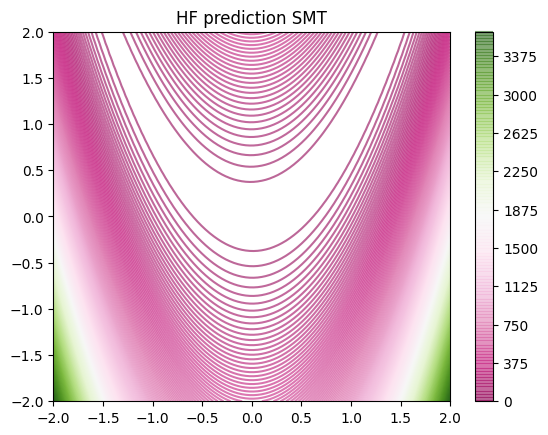

In [17]:
# %% Build the MFK object with 3 levels
sm = MFK() 
# low-fidelity dataset names being integers from 0 to level-1
sm.set_training_values(x_lf, z_LF, name=0)
# high-fidelity dataset without name
sm.set_training_values(x_hf, z_HF)
# train the model
sm.train()

mean_hf = sm.predict_values(x_test)
va_hf = sm.predict_variances(x_test)

mean_lf = sm._predict_intermediate_values(x_test, 1)

fig4 = plt.figure()
axSurrogate4 = fig4.add_subplot(111)
axSurrogate4.set_title('HF prediction SMT')
surf4 = axSurrogate4.contour(xv, yv, mean_hf.reshape((num, num)),
                              300, cmap=cm.PiYG, antialiased=True, alpha=0.6)
fig4.colorbar(surf4)
fig4.show()


 MFCK 




__________Experiment with 2 lvl and 2 Dim________



Training...
Predicting...


D:\mcastano\AppData\Local\Temp\ipykernel_9176\1661272832.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig3.show()


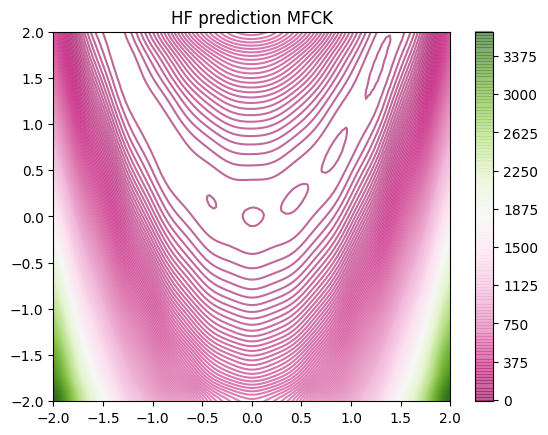

In [18]:
doe = np.vstack([np.hstack([x_lf, np.zeros((x_lf.shape[0],1))]), np.hstack([x_hf, 1*np.ones((x_hf.shape[0],1))])])
doe_response = np.vstack([z_LF.reshape(-1,1), z_HF.reshape(-1,1)])

#Train MFCK
mfck1 = MFCK(hyper_opt=opti,theta0 =[1.])
mfck1.set_training_values(doe, doe_response)

mfck1.train()

means = []
covariances= []

means.append(1)
covariances.append(1)
means.append(1)
covariances.append(1)
means[1],covariances[1],means[0],covariances[0] = mfck1.predict(x_test)

fig3 = plt.figure()
axSurrogate3 = fig3.add_subplot(111)
axSurrogate3.set_title('HF prediction MFCK')
surf3 = axSurrogate3.contour(xv, yv, means[1].reshape((num, num)),
                             300, cmap=cm.PiYG, antialiased=True, alpha=0.6)
fig3.colorbar(surf3)
fig3.show()

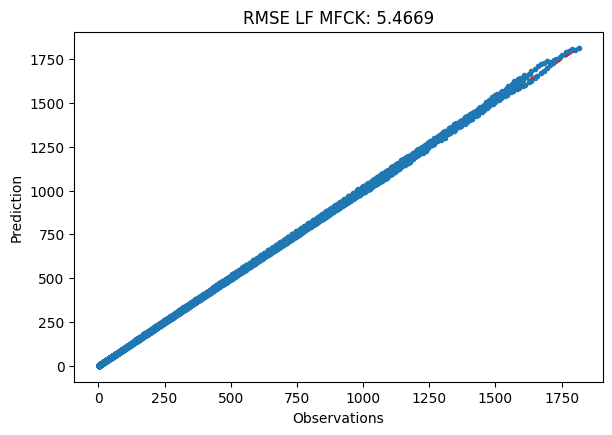

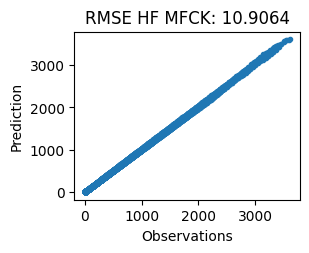

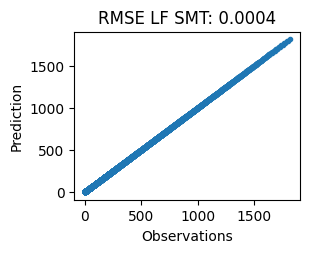

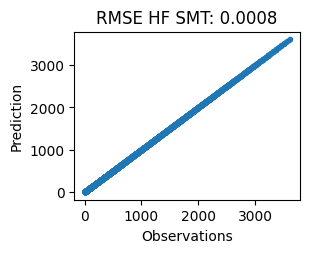

In [19]:
#%%Plot RMSE
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
rmse = np.sqrt(np.mean((z_test_LF.flatten() - means[0].flatten())**2))
# Plot results
start = np.min([means[0], z_test_LF])
end = np.max([means[0], z_test_LF])
#plt.figure(figsize=(8,8))
plt.plot([start, end], [start, end], "r--", linewidth=2)
plt.plot(z_test_LF.flatten(), means[0].flatten(), '.')
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("RMSE LF MFCK: %.4f" %rmse)
plt.show()
plt.subplot(2,2,2)
rmse = np.sqrt(np.mean((z_test_HF.flatten() - means[1].flatten())**2))
# Plot results
start = np.min([means[1], z_test_HF])
end = np.max([means[1], z_test_HF])
#plt.figure(figsize=(8,8))
plt.plot([start, end], [start, end], "r--", linewidth=2)
plt.plot(z_test_HF.flatten(), means[1].flatten(), '.')
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("RMSE HF MFCK: %.4f" %rmse)
plt.show()


plt.subplot(2,2,3)
rmse = np.sqrt(np.mean((z_test_LF.flatten() - mean_lf.flatten())**2))
# Plot results
start = np.min([mean_lf, z_test_LF])
end = np.max([mean_lf, z_test_LF])
plt.plot([start, end], [start, end], "r--", linewidth=2)
plt.plot(z_test_LF.flatten(), mean_lf.flatten(), '.')
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("RMSE LF SMT: %.4f" %rmse)
plt.show()
plt.subplot(2,2,4)
rmse = np.sqrt(np.mean((z_test_HF.flatten() - mean_hf.flatten())**2))
# Plot results
start = np.min([mean_hf, z_test_HF])
end = np.max([mean_hf, z_test_HF])
#plt.figure(figsize=(8,8))
plt.plot([start, end], [start, end], "r--", linewidth=2)
plt.plot(z_test_HF.flatten(), mean_hf.flatten(), '.')
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("RMSE HF SMT: %.4f" %rmse)
plt.show()